In [79]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
from ipywidgets import interactive
from ipywidgets import interactive_output
from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [4]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'

## Load data 

In [5]:
folder = '.'

In [6]:
shape = tuple(np.loadtxt(join(folder, 'a5d_new_shape.txt')).astype(int))
shape

(36, 57, 36, 74, 98)

In [7]:
coords = utils.load_stacked_arrays('coords.npz')
for c in coords:
    print(c.shape)

(36,)
(57,)
(36,)
(74,)
(98,)


In [8]:
f = np.memmap(join(folder, 'a5d_new.mmp'), shape=shape, dtype='float', mode='r')

In [9]:
f.shape

(36, 57, 36, 74, 98)

In [10]:
print(f'min(f) = {np.min(f)}')
f = np.clip(f, 0.0, None)

min(f) = -2.2183848073435786e-14


## Static plots 

In [11]:
dims = ["x", "xp", "y", "yp", "w"]
units = ["mm", "mrad", "mm", "mrad", "MeV"]
dims_units = [f'{d} [{u}]' for d, u in zip(dims, units)]
dim_to_int = {dim: i for i, dim in enumerate(dims)}

### Projections

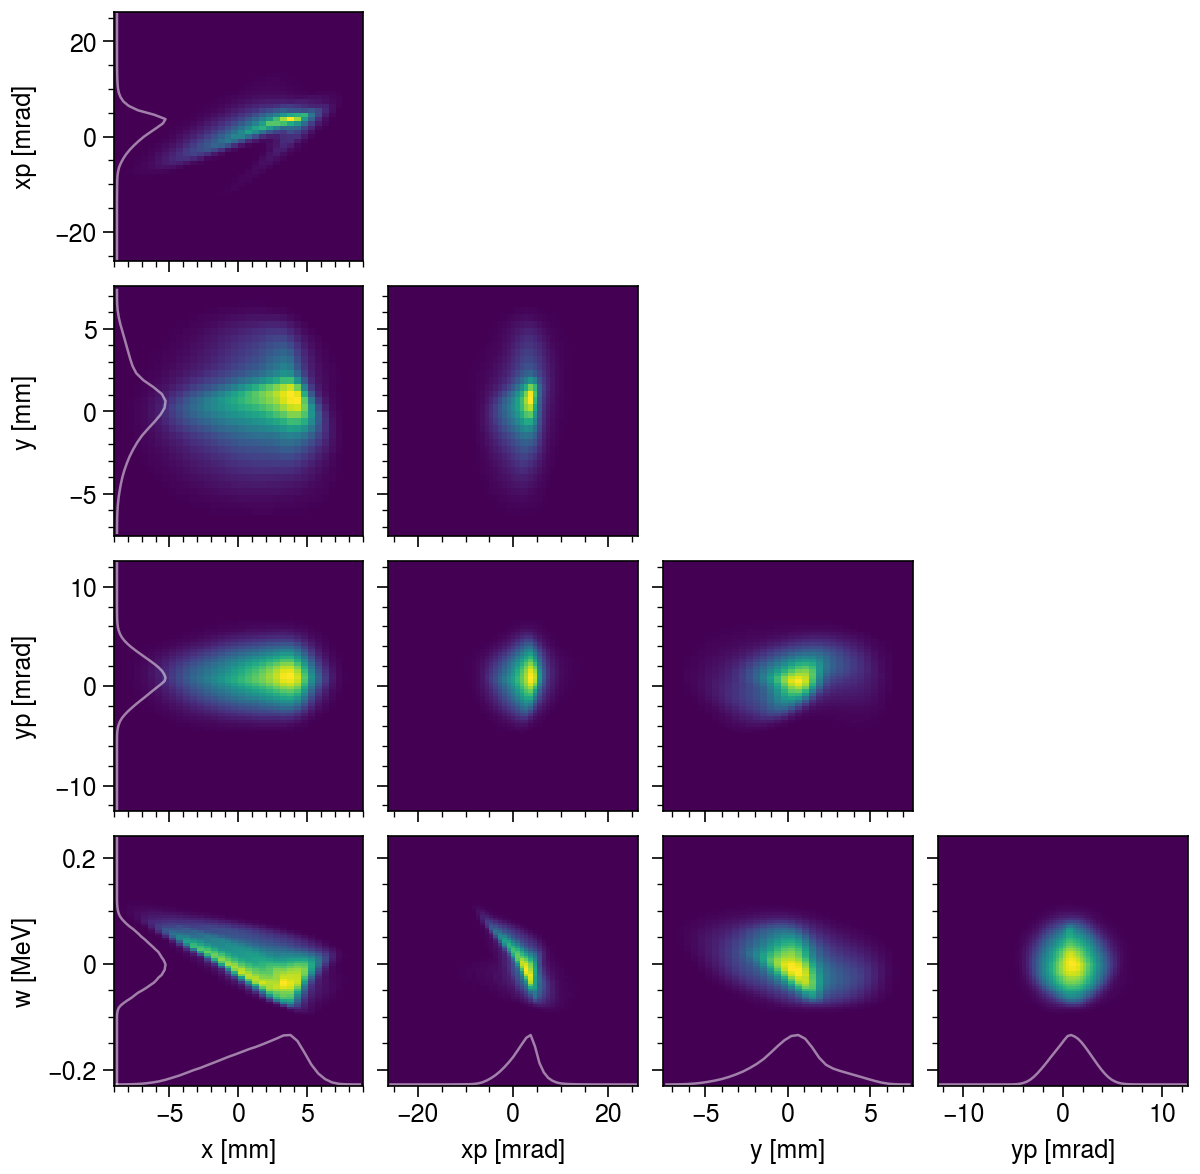

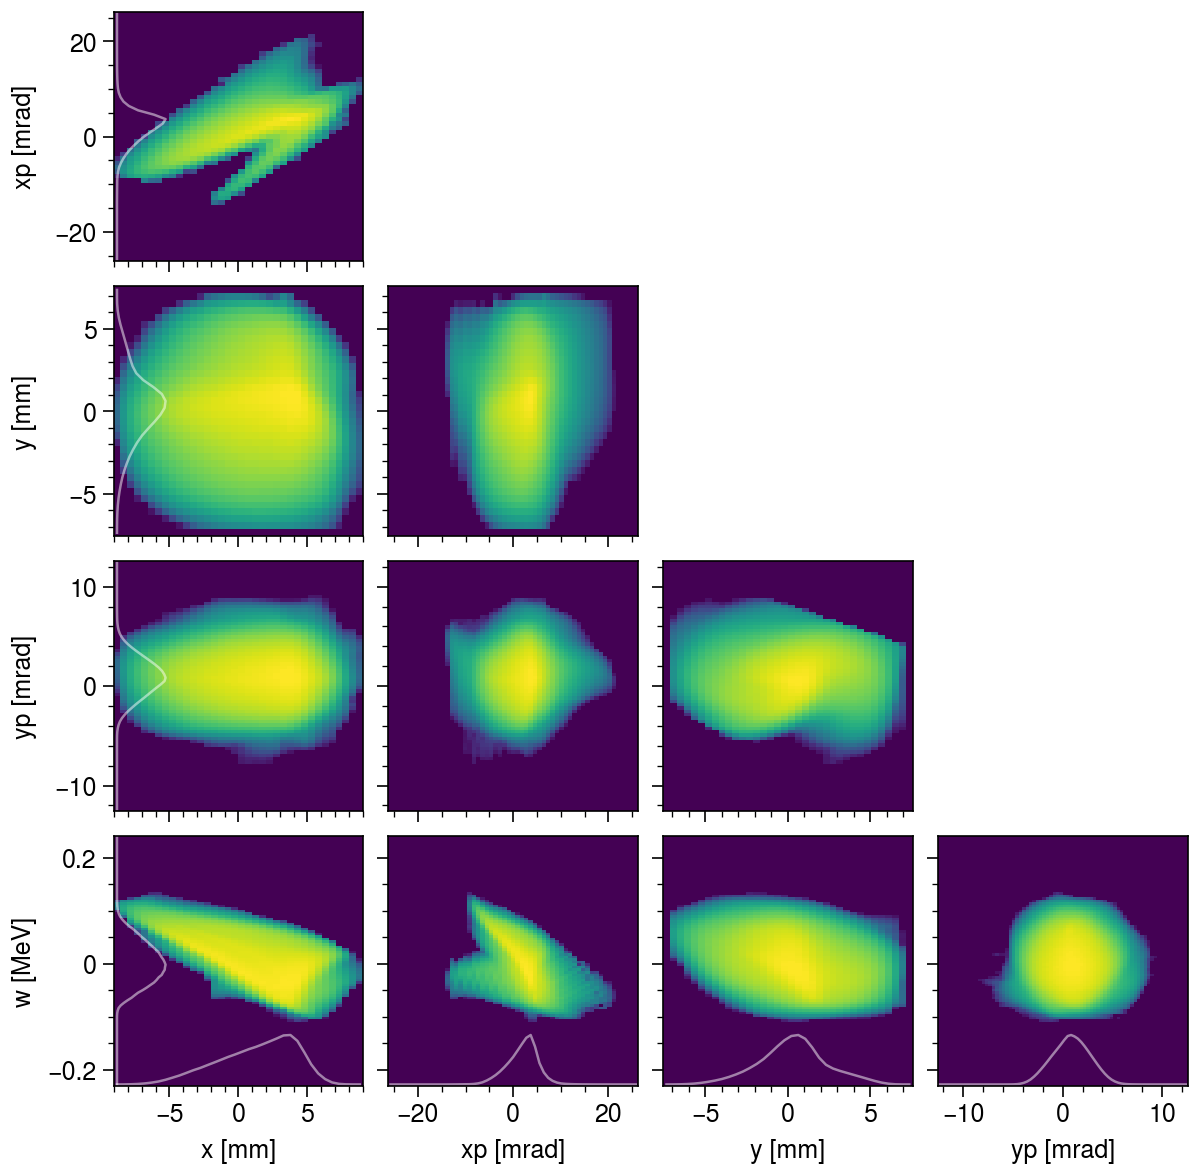

In [12]:
for norm in [None, 'log']:
    axes = mplt.corner(
        f[:, :, :, :, ::-1],
        coords=coords,
        fig_kws=dict(figwidth=1.5*4, space=1),
        diag_kind='None',
        prof='edges',
        prof_kws=dict(alpha=0.5, lw=0.9),
        labels=dims_units,
        norm=norm,
        frac_thresh=1e-6,
    )
    plt.savefig(f'_output/corner_int_norm{norm}.png')
    plt.show()

### Slices

In [13]:
ind = np.unravel_index(np.argmax(f), f.shape)
ind = tuple([i for i in ind])
print(ind)

(25, 33, 21, 39, 63)


In [14]:
_dims = ["x", "xp", "y", "yp", "w"]
_units = ["mm", "mrad", "mm", "mrad", "MeV"]

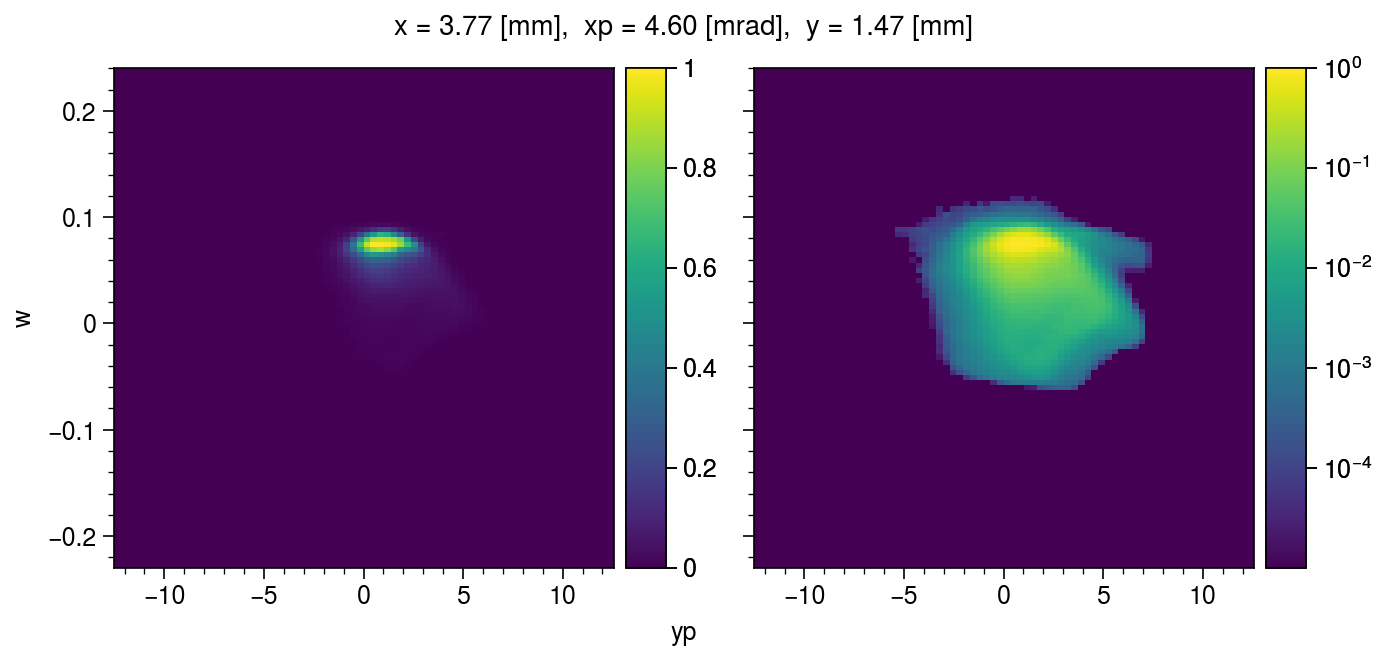

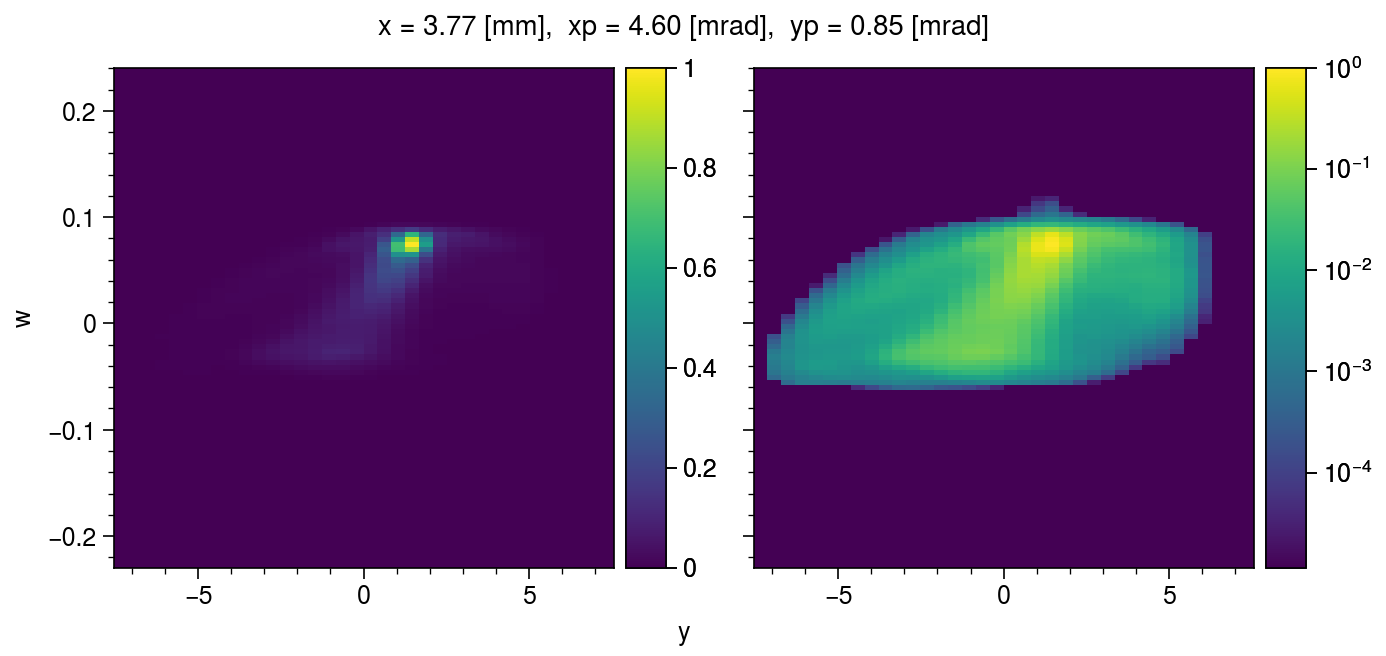

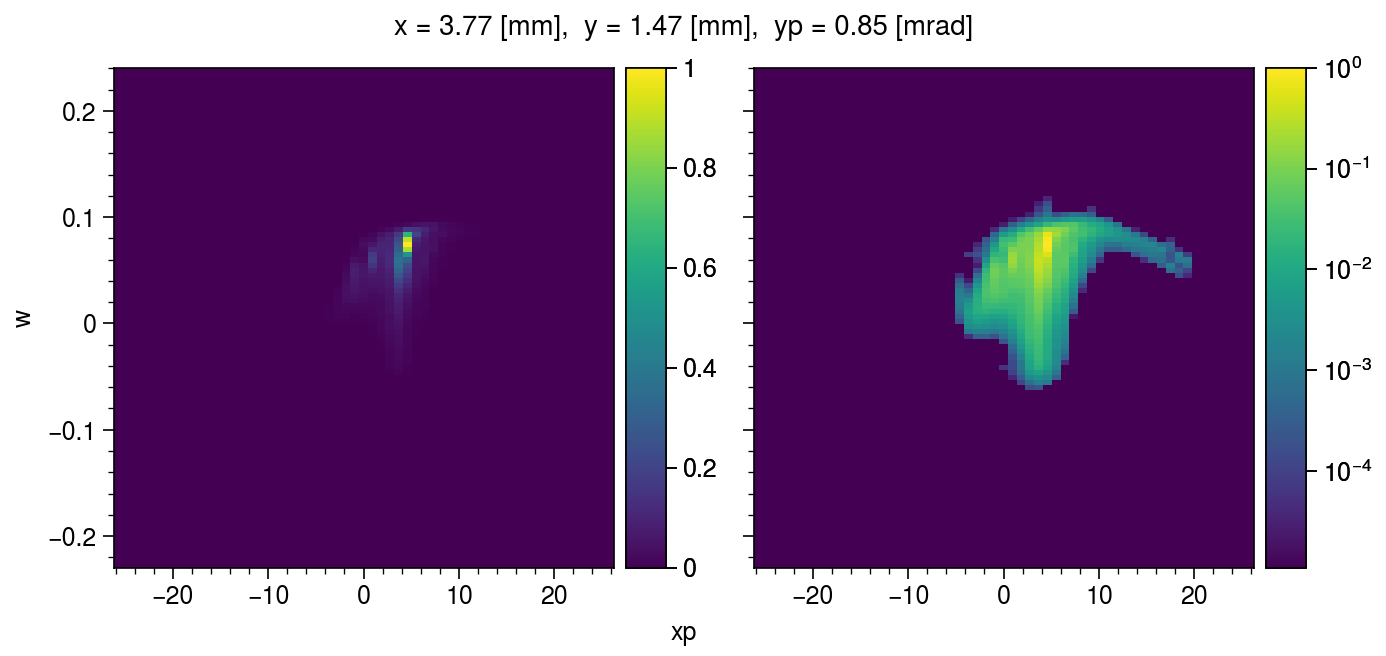

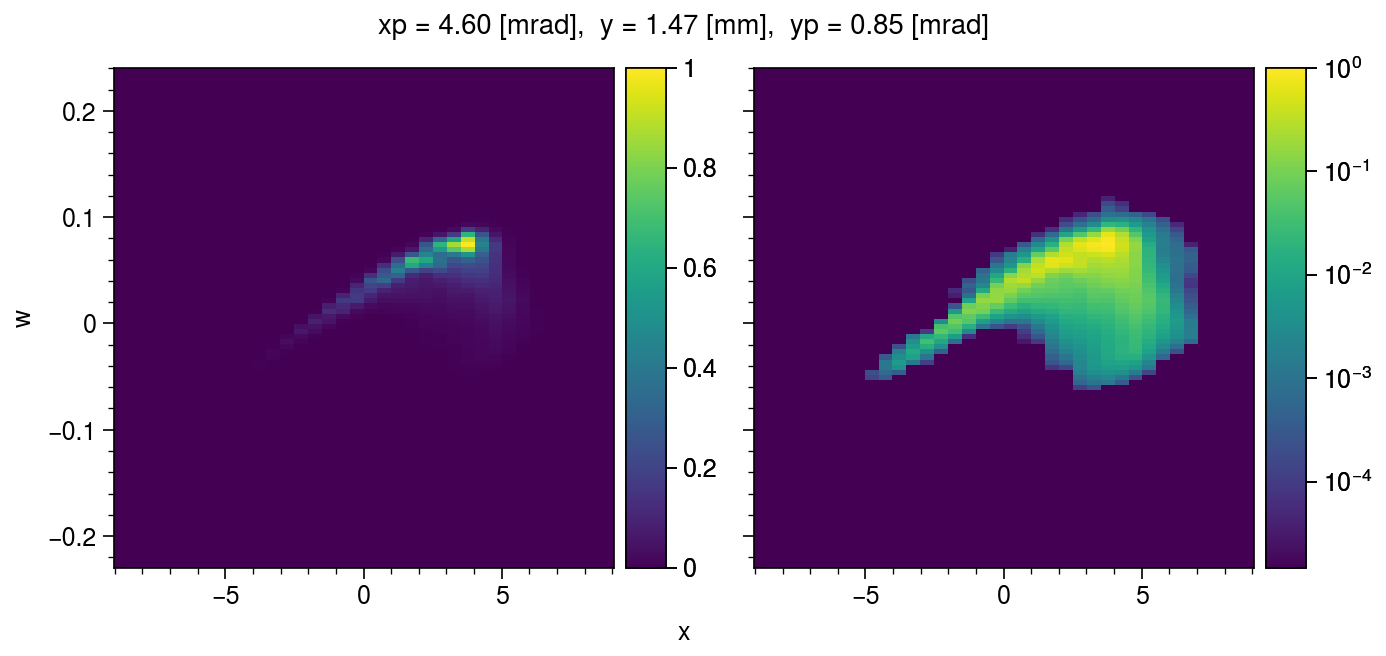

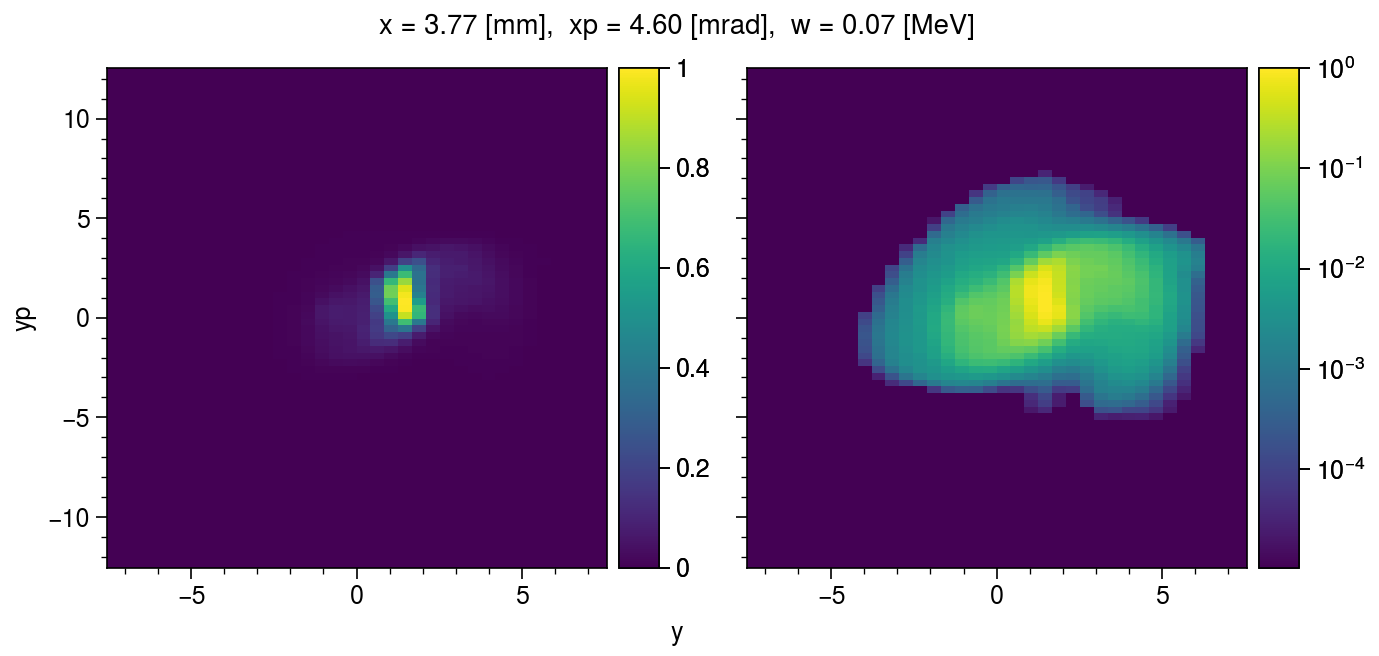

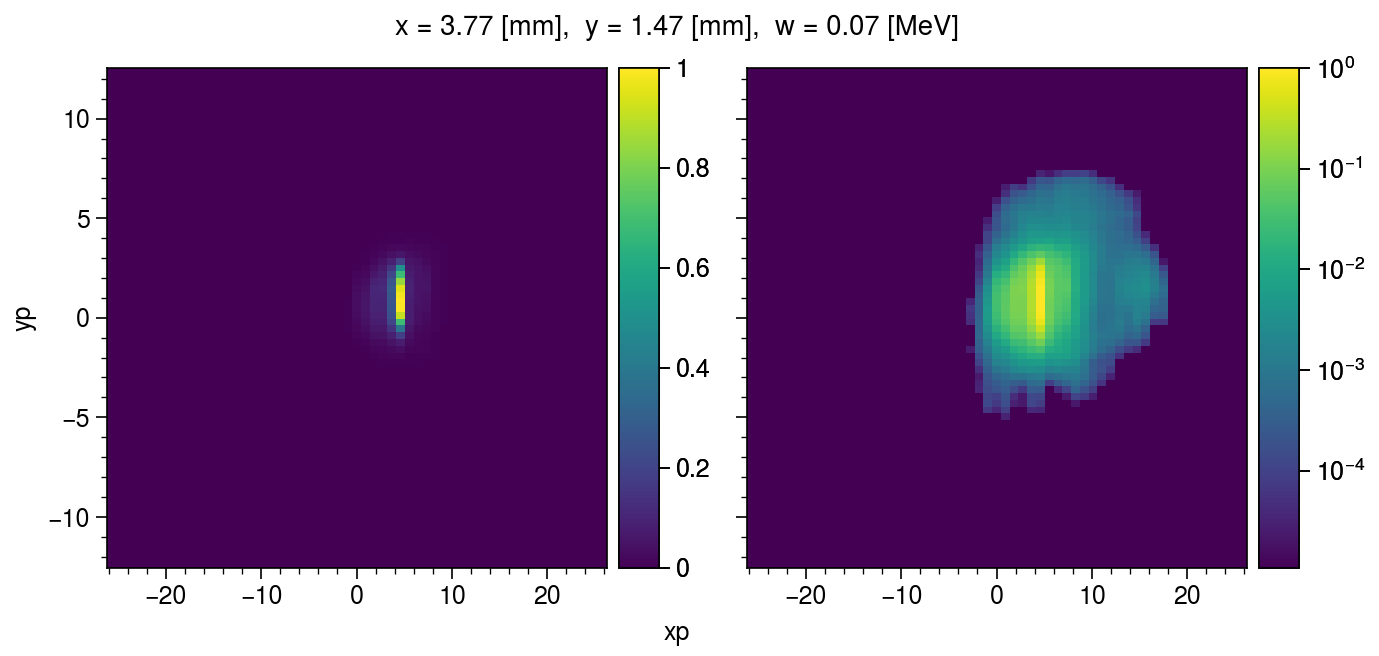

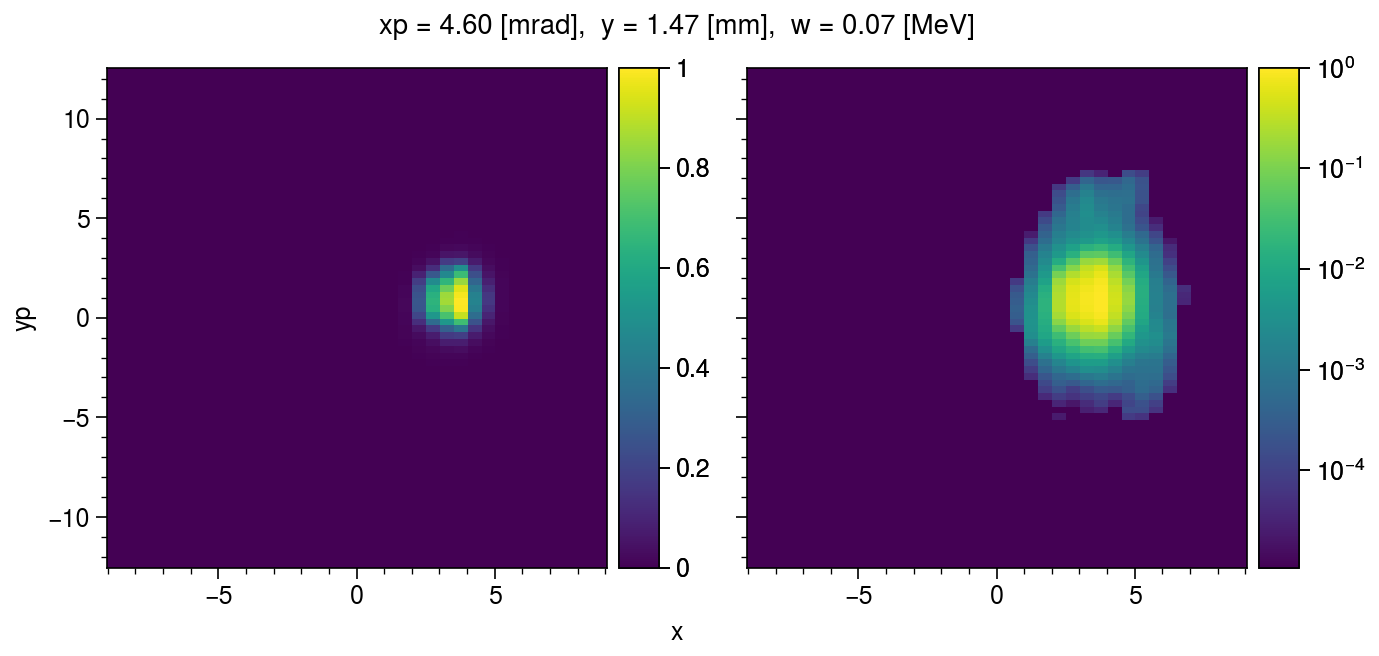

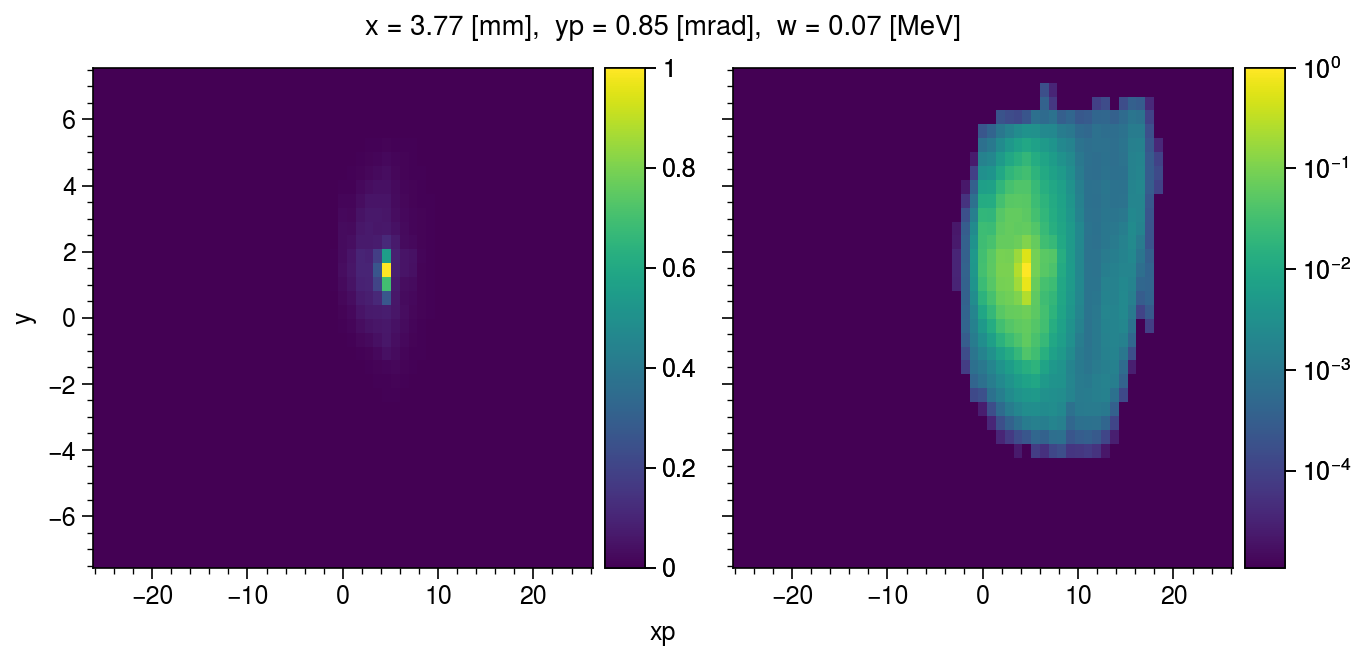

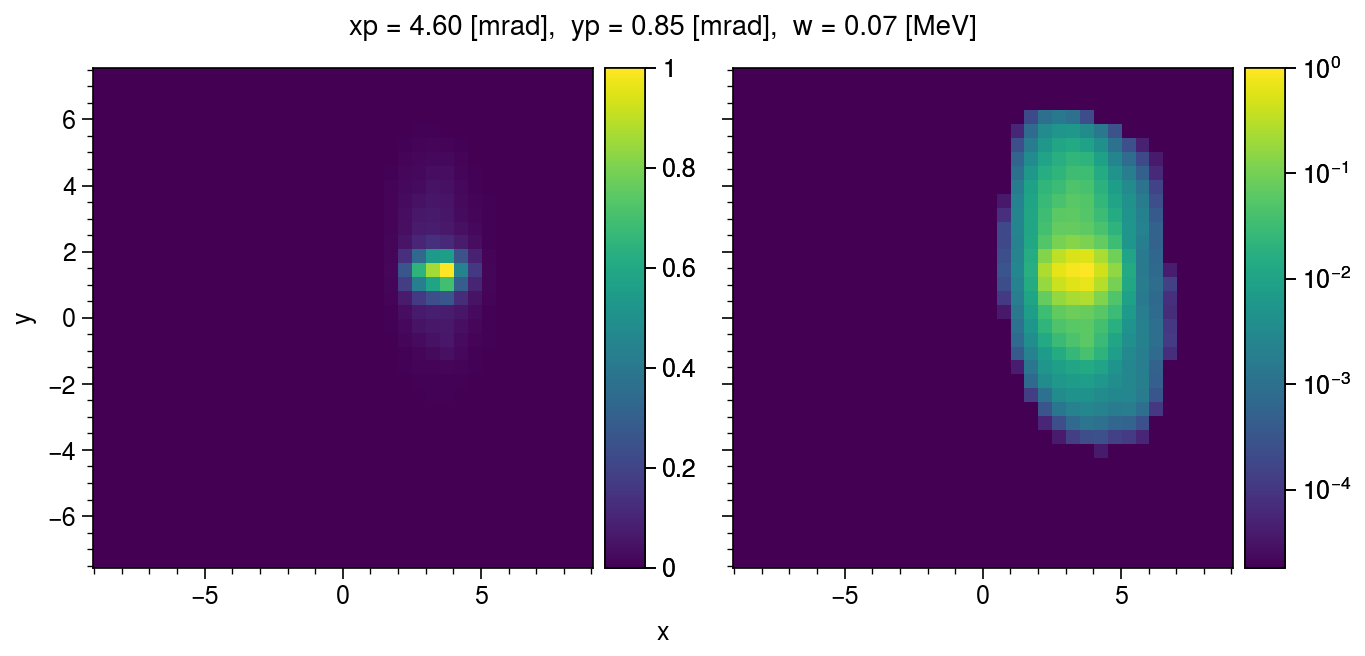

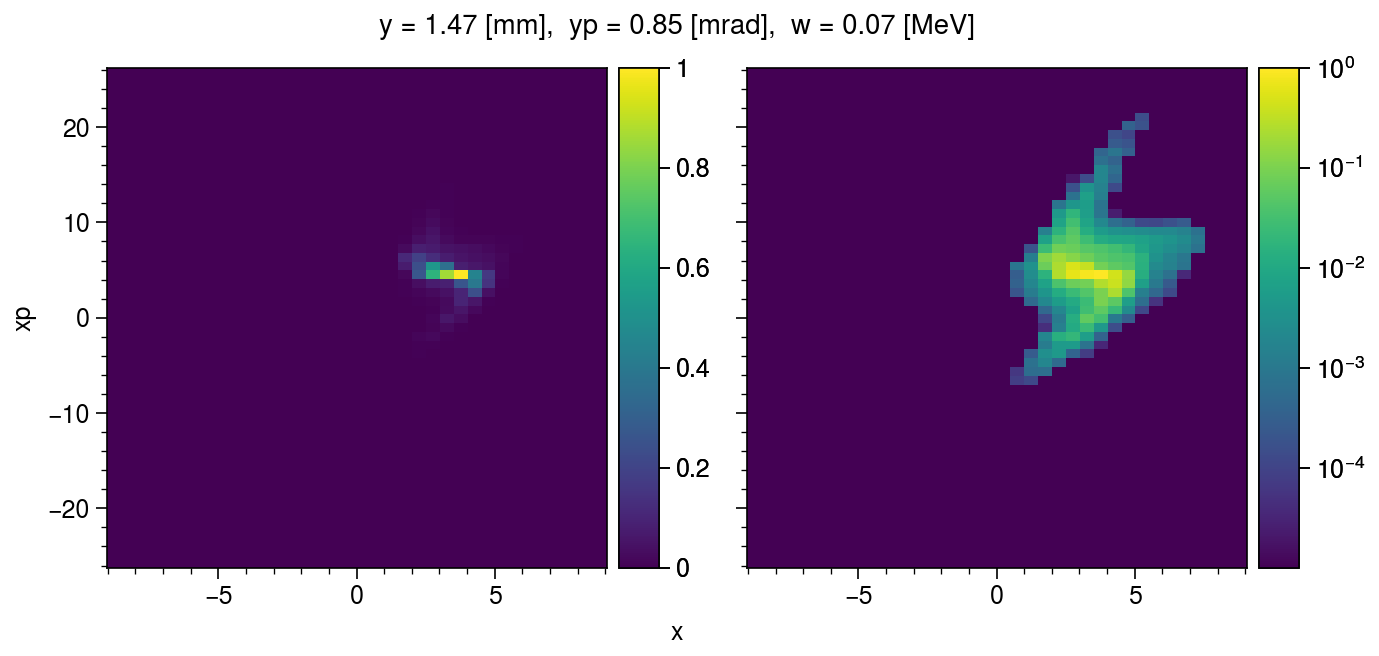

In [15]:
frac_thresh = 1e-5
axes_slice = [(k, j, i) for i in range(f.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(f.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    f_slice = f[idx]
    f_slice = f_slice / np.max(f_slice)
    
    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(f_slice, x=coords[axis_view[0]], y=coords[axis_view[1]], ax=ax, frac_thresh=frac_thresh, norm=norm, colorbar=True)
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = '_output/slice_'
    for i in axis:
        string += f'{_dims[i]}-{ind[i]}'
    __dims = [_dims[i] for i in axis]
    __units = [_units[i] for i in axis]
    _vals = [coords[i][ind[i]] for i in axis]
    plot_axes.format(suptitle=f'{__dims[0]} = {_vals[0]:.2f} [{__units[0]}],  {__dims[1]} = {_vals[1]:.2f} [{__units[1]}],  {__dims[2]} = {_vals[2]:.2f} [{__units[2]}]')
    plot_axes.format(suptitle_kw=dict(fontweight='normal'))
    plt.savefig(string + '.png')
    plt.show()

## Interactive plots

In [16]:
cmaps = ['viridis', 'dusk_r', 'mono_r', 'plasma']

Pre-compute the full 2D projections.

In [17]:
projections = []
for i in trange(5):
    projections.append([])
    for j in range(5):
        projections[i].append(utils.project(f, (i, j)))

100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


### Projections 

In [18]:
def update_projection(dim1, dim2, cmap, thresh, log, discrete, contour, profiles):
    if dim1 == dim2:
        return
    i, j = [dim_to_int[dim] for dim in [dim1, dim2]]
    H = projections[i][j]
    
    fig, ax = pplt.subplots()
    mplt.plot_image(
        H / np.max(H), x=coords[i], y=coords[j], ax=ax, 
        norm='log' if log else None,
        frac_thresh=10.0**thresh,
        discrete=discrete,
        cmap=cmap,
        colorbar=True,
        profx=profiles,
        profy=profiles,
        prof_kws=dict(lw=1.0, alpha=0.75, color='white', scale=0.15),
        contour=contour,
        contour_kws=None,
    )
    ax.format(xlabel=dims_units[i], ylabel=dims_units[j])
    plt.show()

In [19]:
def update_projection_panels(dim1, dim2, cmap, thresh, log, discrete, contour, profiles):
    """Plots projections on panel axes (top/right)."""
    if dim1 == dim2:
        return
    i, j = [dim_to_int[dim] for dim in [dim1, dim2]]
    x = coords[i]
    y = coords[j]
    H = projections[i][j] / np.max(projections[i][j])
    
    fig, ax = pplt.subplots()
    if profiles:
        px = np.sum(H, axis=1)
        py = np.sum(H, axis=0)
        paxes = [ax.panel_axes(loc, space=0, width='3em') for loc in 'tr']
        for pax in paxes:
            pax.format(xspineloc='neither', yspineloc='neither')
        kw = dict(color='black', lw=1.0)
        paxes[0].plot(x, px, **kw)
        paxes[1].plotx(y, py, **kw)
    ax, mesh = mplt.plot_image(
        H, x=x, y=y, ax=ax, 
        frac_thresh=10.0**thresh,
        contour=contour,
        contour_kws=None,
        return_mesh=True,
        norm='log' if log else None,
        discrete=discrete,
        cmap=cmap,
    )
    if colorbar:
        space = 2 if profiles else None
        ax.colorbar(mesh, space=space)

    ax.format(xlabel=dims_units[i], ylabel=dims_units[j])
    plt.show()

In [20]:
dim1 = widgets.Dropdown(options=dims, index=2, description='dim 1')
dim2 = widgets.Dropdown(options=dims, index=3, description='dim 2')
cmap = widgets.Dropdown(options=cmaps, description='cmap')
thresh = widgets.FloatSlider(value=-5.0, min=-8.0, max=0.0,  
                             step=0.1, description='thresh')
discrete = widgets.Checkbox(value=False, description='discrete')
log = widgets.Checkbox(value=False, description='log')
contour = widgets.Checkbox(value=False, description='contour')
profiles = widgets.Checkbox(value=True, description='profiles')

kwargs = dict(dim1=dim1, dim2=dim2, cmap=cmap,
              thresh=thresh, log=log, discrete=discrete, contour=contour, profiles=profiles)
interactive(update_projection, **kwargs)

interactive(children=(Dropdown(description='dim 1', index=2, options=('x', 'xp', 'y', 'yp', 'w'), value='y'), …

Here is a simple example showing how to use `widgets.Output`.

In [199]:
# prof_kws = dict(color='white', lw=1.0, alpha=0.75)
prof_kws = dict(marker='.', color='red', lw=0)
plot_kws = dict(ec='None')

In [ ]:
%%capture

n = 5
fig, axes = pplt.subplots(nrows=n-1, ncols=n-1, spanx=False, spany=False, 
                          aligny=True, figwidth=1.5*(n-1), space=1.1)
meshes = [[], [], [], []]
px_lines = [[], [], [], []]
py_lines = [[], [], [], []]
for i in range(n - 1):
    axes[0, i].format(xlabel=dims_units[i])
    axes[i, 0].format(ylabel=dims_units[i + 1])
    for j in range(n - 1):
        ax = axes[i, j]
        if j > i:
            ax.axis('off')
            continue
        x = coords[j]
        y = coords[i + 1]

        H = utils.project(f, (j, i + 1))
        mesh = ax.pcolormesh(x, y, H.T, **plot_kws)
        meshes[i].append(mesh)
        
        px_line, = ax.plot([], [], **prof_kws)
        px_lines[i].append(px_line)
        
        py_line, = ax.plot([], [], **prof_kws)
        py_lines[i].append(py_line)
        
        for item in [px_line, py_line]:
            item.set_visible(False)
            
        
def update(xrange, xprange, yrange, yprange, wrange, prof=True):
    # Slice the array.
    print('Making slice...')
    ranges = [xrange, xprange, yrange, yprange, wrange]
    mask = np.full(f.shape, False)
    for i, (umin, umax) in enumerate(ranges):
        idx = 5 * [slice(None)]
        idx[i] = np.logical_or(coords[i] < umin, coords[i] > umax)
        mask[tuple(idx)] = True
    f_slice = np.ma.masked_where(mask, f)
        
    print('Updating display...')
    for i in range(n - 1):
        for j in range(i + 1):
            x = coords[i + 1]
            y = coords[j]
            H = utils.project(f_slice, (j, i + 1))
            meshes[i][j].set_array(H.T)
            meshes[i][j].set_norm(colors.Normalize(np.min(H), np.max(H)))
    display(fig)
    clear_output(wait=True)

In [ ]:
ranges = []
for i in range(5):
    xmin, xmax = np.min(coords[i]), np.max(coords[i])
    delta = np.diff(coords[i])[0]
    xrange = widgets.FloatRangeSlider(
        value=[xmin, xmax],
        min=xmin,
        max=xmax,
        step=delta,
        description=f'{dims[i]}',
    )
    ranges.append(xrange)

In [ ]:
kwargs = dict(xrange=ranges[0], xprange=ranges[1], yrange=ranges[2], 
              yprange=ranges[3], wrange=ranges[4],
              cmap=cmap, thresh=thresh, discrete=discrete, log=log, 
              contour=contour, profiles=profiles)
widgets.interact(update, **kwargs)